# Pre-Processing : Library and Data file import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)
pd.set_option('display.max_columns', 999)

In [2]:
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import gc

/Users/arielliwenxi/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
gc.collect()

40

In [ ]:
electronics = pd.read_csv("elecs.csv")

In [5]:
cosmetics = pd.read_pickle('shoppersnew.pkl')

# 1. Processing data for appropriate Date-Time Values

In [6]:
df = cosmetics.copy()
df.drop('category_id',axis=1,inplace=True)

In [7]:
# Month

MM = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df['month'] = pd.DatetimeIndex(df['event_time']).month.map(MM)

In [8]:
# Weekday

dayOfWeek={0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fr', 5:'Sat', 6:'Sun'}
df['weekday'] = pd.DatetimeIndex(df['event_time']).weekday.map(dayOfWeek)

In [9]:
# Phase of day

df['hour'] = pd.DatetimeIndex(df['event_time']).hour
timeOfDay={0:'Dawn',1:'Dawn',2:'Dawn',3:'Dawn',4:'Dawn',5:'EarlyMorning',6:'EarlyMorning',7:'EarlyMorning',8:'EarlyMorning', 9:'Morning',10:'Morning',11:'Morning', 12:'Noon', 13:'Afternoon',14:'Afternoon',15:'Afternoon',16:'Afternoon', 17:'Evening',18:'Evening',19:'Evening',20:'Evening', 21:'Night',22:'Night',23:'Night', 24:'Midnight'}
df['timeOfDay'] = df.hour.map(timeOfDay)

In [10]:
# Is Weekend?

df['Weekend']= df.weekday.apply(lambda x : 1 if x in ['Sunday','Saturday'] else 0)

In [11]:
#Is holiday?
holidaysDF = pd.read_csv("holidays.csv")

holidaysList = []
for item in holidaysDF['Date'].to_list():
    holidaysList.append(pd.Timestamp(item))

Holiday = df.event_time.apply(lambda x : 1 if x in holidaysList else 0)
df['Holiday']= Holiday

In [12]:
df.head(3)

,event_time,event_type,product_id,brand,price,user_id,user_session,year,month,weekday,hour,timeOfDay,Weekend,Holiday
0,2019-12-01 00:00:00,remove_from_cart,5712790,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,Dec,Sun,0,Dawn,0,0
1,2019-12-01 00:00:00,view,5764655,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019,Dec,Sun,0,Dawn,0,0
2,2019-12-01 00:00:02,cart,4958,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019,Dec,Sun,0,Dawn,0,0


# 2. Creating Features

## Features to build:

    Weekday(Sun/Mon/...) [One hot encoded]
    Month [One hot encoded]
    TimeOfDay(Morning/Evening/....) [One hot encoded]
    InteractionTime(Duration of Session in seconds)
    
    #TotalEventsInSession()
    #ViewEventsInSession
    #CartEventsInSession
    
    #CategoriesViewedInSession
    #CategoriesCartedInSession
    #BrandsViewedInSession
    #BrandsCartedInSession
    #ProductsViewedInSession
    #ProductsCartedInSession
    
    AverageAmountViewedInSession
    AverageAmountCartedInSession
    
    #HolidaysDuringSession()
    #WeekendDuringSession()
    
    LastSession(1: if the Session is last for a user, 0 if not)
    
    ViewToCartTime (Time between viewing and carting in session)
    
    Other suggested Features:
        AvgPRDViewbyUser (total products viewed/total sessions by user)
        AvgPRDCartbyUser  (total products carted/total sessions by user)
        AvgCTGViewbyUser (total categories viewed/total sessions by user)
        AvgCTGCartbyUser (total categories viewed/total sessions by user)

## ADDING COLUMNS TO DF -  AMOUNT BY USER FOR DIFFERENT EVENTS

In [13]:
AmountbyUser = pd.pivot_table(df, index='user_id',columns='event_type',values='price',fill_value=0)
AmountbyUser = AmountbyUser.rename(columns={'cart':'OverallAmtUserCarted','purchase':'OverallAmtUserPurchased','view':'OverallAmtUserViewed'})
df = pd.merge(df,AmountbyUser,on='user_id',how='outer')

In [14]:
df.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,year,month,weekday,hour,timeOfDay,Weekend,Holiday,OverallAmtUserCarted,OverallAmtUserPurchased,remove_from_cart,OverallAmtUserViewed
0,2019-12-01 00:00:00,remove_from_cart,5712790,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,Dec,Sun,0,Dawn,0,0,3.626831,3.647031,4.492705,4.341205
1,2019-12-01 00:00:44,remove_from_cart,5650294,metzger,3.33,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,Dec,Sun,0,Dawn,0,0,3.626831,3.647031,4.492705,4.341205
2,2019-12-01 00:00:46,remove_from_cart,5692261,staleks,6.35,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,Dec,Sun,0,Dawn,0,0,3.626831,3.647031,4.492705,4.341205
3,2019-12-01 00:00:49,remove_from_cart,5694628,yoko,3.65,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,Dec,Sun,0,Dawn,0,0,3.626831,3.647031,4.492705,4.341205
4,2019-12-01 00:00:58,view,5817779,irisk,0.79,576802932,f7257a5b-5449-4136-aa56-e373f484ffa2,2019,Dec,Sun,0,Dawn,0,0,3.626831,3.647031,4.492705,4.341205


# Product Discount

In [14]:
product = df.groupby('product_id')

In [15]:
max_price = product['price'].max()

In [16]:
df = pd.merge(df,max_price,on = 'product_id', how = 'left')

In [17]:
df = df.rename(columns = {'price_x':'price','price_y':'max_price'})

In [18]:
df['discount'] = df['max_price'] - df['price']

In [19]:
Discount_cart = df.apply(lambda x: (x['discount'] if x['event_type'] == 'cart' else 0),axis = 1)
Discount_view = df.apply(lambda x: (x['discount'] if x['event_type'] == 'view' else 0),axis = 1)
Discount_remove = df.apply(lambda x: (x['discount'] if x['event_type'] == 'remove_from_cart' else 0),axis = 1)


In [20]:
df['Discount_cart'] = Discount_cart
df['Discount_view'] = Discount_view
df['Discount_remove'] = Discount_remove

In [39]:
df.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,year,month,weekday,hour,timeOfDay,Weekend,Holiday,OverallAmtUserCarted,OverallAmtUserPurchased,remove_from_cart,OverallAmtUserViewed,max_price,discount,Discount_cart,Discount_view,Discount_remove,dummy
0,2019-12-01 00:00:00,remove_from_cart,5712790,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,Dec,Sun,0,Dawn,0,0,3.626831,3.647031,4.492705,4.341205,6.27,0.0,0.0,0.0,0.0,0.0
1,2019-12-01 00:00:44,remove_from_cart,5650294,metzger,3.33,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,Dec,Sun,0,Dawn,0,0,3.626831,3.647031,4.492705,4.341205,3.33,0.0,0.0,0.0,0.0,0.0
2,2019-12-01 00:00:46,remove_from_cart,5692261,staleks,6.35,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,Dec,Sun,0,Dawn,0,0,3.626831,3.647031,4.492705,4.341205,6.35,0.0,0.0,0.0,0.0,0.0
3,2019-12-01 00:00:49,remove_from_cart,5694628,yoko,3.65,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,Dec,Sun,0,Dawn,0,0,3.626831,3.647031,4.492705,4.341205,3.65,0.0,0.0,0.0,0.0,0.0
4,2019-12-01 00:00:58,view,5817779,irisk,0.79,576802932,f7257a5b-5449-4136-aa56-e373f484ffa2,2019,Dec,Sun,0,Dawn,0,0,3.626831,3.647031,4.492705,4.341205,0.79,0.0,0.0,0.0,0.0,0.0


## GROUPING THE DATA

In [40]:
GroupUS = df.sort_values('event_time').groupby(['user_session'])

## Total Number of Events/Interactions in Session

In [41]:
Features= GroupUS['event_type'].count().reset_index().rename(columns={'event_type':'TotalEventsInSession'})

## Duration

In [23]:
# # Defining function to return range of any given series
def ammd(series):
     return (max(series)-min(series))

In [43]:
interactionTime = GroupUS['event_time'].agg(ammd)
interactionTime = interactionTime.dt.total_seconds()
Features = pd.merge(Features,interactionTime, how ='outer', on = ['user_session'])
Features = Features.rename(columns={'event_time':'interactionTime'})

##  Number of Interactions by Event Type in Session

In [44]:
NumEventTime = GroupUS['event_type'].value_counts().unstack(fill_value = 0).rename(columns={'view':'#TimesViewedinSession','cart':'#TimesCartedinSession','purchase':'#TimesPurchasedinSession'})
Features = pd.merge(Features,NumEventTime, how ='outer', on = ['user_session'])

## Discounts

In [45]:
Features['Discount_carted'] = GroupUS['Discount_cart'].sum().values
Features['Discount_viewed'] = GroupUS['Discount_view'].sum().values
Features['Discount_removed'] = GroupUS['Discount_remove'].sum().values


## AVERAGE AMOUNT BY EVENT IN SESSION

In [46]:
AmountbyEvent = pd.pivot_table(df, index='user_session',columns='event_type',values='price',fill_value=0)
AmountbyEvent = AmountbyEvent.rename(columns={'cart':'AvgAmtCartedInSession','purchase':'AvgAmtPurchasedInSession','view':'AvgAmtViewedInSession'})
Features = pd.merge(Features,AmountbyEvent,on='user_session',how='outer')

## BRAND COUNT BY EVENT IN SESSION

In [47]:
BrandsBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='brand',aggfunc='count',fill_value=0)
BrandsBySession = BrandsBySession.rename(columns={'view':'#BrandsViewedInSession','cart':'#BrandsCartedInSession','purchase':'#BrandsPurchasedInSession'})
Features = pd.merge(Features,BrandsBySession,on='user_session',how='outer')

## CATEGORY COUNT BY EVENT IN SESSION

In [ ]:
CategoriesBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='category_code',aggfunc='count',fill_value=0)
CategoriesBySession = CategoriesBySession.rename(columns={'view':'#CategoriesViewedInSession','cart':'#CategoriesCartedInSession','purchase':'#CategoriesPurchasedInSession'})
Features = pd.merge(Features,CategoriesBySession,on='user_session',how='outer')

In [48]:
Features.head(1)

,user_session,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,remove_from_cart_x,#TimesViewedinSession,Discount_carted,Discount_viewed,Discount_removed,AvgAmtCartedInSession,AvgAmtPurchasedInSession,remove_from_cart_y,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsPurchasedInSession,remove_from_cart,#BrandsViewedInSession
0,0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,194.44,0,0,0,1


## ADDING FEATURES FOR AVERAGE OVERALL AMOUNT BY USER FOR DIFFERENT EVENTS

In [49]:
OverallAmtUserCarted = df.groupby('user_session')['OverallAmtUserCarted'].mean()
OverallAmtUserViewed = df.groupby('user_session')['OverallAmtUserViewed'].mean()
OverallAmtUserPurchased = df.groupby('user_session')['OverallAmtUserPurchased'].mean()

#Merging these individual dataframes

Features = pd.merge(Features,OverallAmtUserCarted.reset_index(), how='outer',on = ['user_session'])
Features = pd.merge(Features,OverallAmtUserViewed.reset_index(), how='outer',on = ['user_session'])
Features = pd.merge(Features,OverallAmtUserPurchased.reset_index(), how='outer',on = ['user_session'])

In [34]:
Features.head(1)

,user_session,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,remove_from_cart_x,#TimesViewedinSession,AvgAmtCartedInSession,AvgAmtPurchasedInSession,remove_from_cart_y,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsPurchasedInSession,remove_from_cart,#BrandsViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased
0,0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0,0,0,0,1,0.0,0.0,0.0,194.44,0,0,0,1,4.543833,9.244298,2.264476


## PRODUCT COUNT BY EVENT IN SESSION

In [50]:
ProductsBySession= pd.pivot_table(df, index='user_session',columns='event_type',values='product_id',aggfunc='count',fill_value=0)
ProductsBySession = ProductsBySession.rename(columns={'view':'#ProdsViewedInSession','cart':'#ProdsCartedInSession','purchase':'#ProdsPurchasedInSession'})
Features = pd.merge(Features,ProductsBySession,on='user_session',how='outer')

In [79]:
Features.head(1)

,user_session,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,remove_from_cart_x,#TimesViewedinSession,AvgAmtCartedInSession,AvgAmtPurchasedInSession,remove_from_cart_y,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsPurchasedInSession,remove_from_cart_x,#BrandsViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,#ProdsCartedInSession,#ProdsPurchasedInSession,remove_from_cart_y,#ProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,2020,Dec,Feb,Jan,Nov,Oct,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Holiday,Weekend,Purchase,Discount_carted,Discount_viewed,Discount_removed
0,0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0,0,0,0,1,0.0,0.0,0.0,194.44,0,0,0,1,4.543833,9.244298,2.264476,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0.0


****************************************

Adding a dummy column for one-hot encoding values easily

In [51]:
df['dummy']= np.zeros(len(df))

## Adding Date and Time Features 

In [52]:
weekday = pd.pivot_table(df, index='user_session',columns='weekday',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [53]:
year =  pd.pivot_table(df, index='user_session',columns='year',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [54]:
month =  pd.pivot_table(df, index='user_session',columns='month',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [55]:
timeOfDay =  pd.pivot_table(df, index='user_session',columns='timeOfDay',values='dummy',fill_value=0, aggfunc=lambda x: len(x.unique()) )

In [56]:
Features = pd.merge(Features,weekday,on='user_session',how='outer')
Features = pd.merge(Features,year,on='user_session',how='outer')
Features = pd.merge(Features,month,on='user_session',how='outer')
Features = pd.merge(Features,timeOfDay,on='user_session',how='outer')

In [42]:
Features.head(1)

,user_session,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesPurchasedinSession,remove_from_cart_x,#TimesViewedinSession,AvgAmtCartedInSession,AvgAmtPurchasedInSession,remove_from_cart_y,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsPurchasedInSession,remove_from_cart_x,#BrandsViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,OverallAmtUserPurchased,#ProdsCartedInSession,#ProdsPurchasedInSession,remove_from_cart_y,#ProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,2020,Dec,Feb,Jan,Nov,Oct,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon
0,0000061d-f3e9-484b-8c73-e54f355032a3,1,0.0,0,0,0,1,0.0,0.0,0.0,194.44,0,0,0,1,4.543833,9.244298,2.264476,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0


In [57]:
Holiday = GroupUS['Holiday'].sum()
Weekend = GroupUS['Weekend'].sum()

In [60]:
Features = pd.merge(Features,Holiday,on='user_session',how='outer')
Features = pd.merge(Features,Weekend,on='user_session',how='outer')

## Dropping all Purchase related Columns and adding Y label 'Purchase'

In [58]:
Features['Purchase'] = Features.AvgAmtPurchasedInSession.apply(lambda x : 1 if x!=0 else 0)

In [61]:
Features.columns

Index([             'user_session',      'TotalEventsInSession',
                 'interactionTime',     '#TimesCartedinSession',
        '#TimesPurchasedinSession',        'remove_from_cart_x',
           '#TimesViewedinSession',           'Discount_carted',
                 'Discount_viewed',          'Discount_removed',
           'AvgAmtCartedInSession',  'AvgAmtPurchasedInSession',
              'remove_from_cart_y',     'AvgAmtViewedInSession',
          '#BrandsCartedInSession', '#BrandsPurchasedInSession',
              'remove_from_cart_x',    '#BrandsViewedInSession',
            'OverallAmtUserCarted',      'OverallAmtUserViewed',
         'OverallAmtUserPurchased',     '#ProdsCartedInSession',
        '#ProdsPurchasedInSession',        'remove_from_cart_y',
           '#ProdsViewedInSession',                        'Fr',
                             'Mon',                       'Sat',
                             'Sun',                       'Thu',
                         

In [62]:
FeaturesDF = Features.drop(columns=['user_session',
                                    '#TimesPurchasedinSession',
                                    '#BrandsPurchasedInSession', 
                                    'AvgAmtPurchasedInSession',
                                   'OverallAmtUserPurchased',
                                   '#ProdsPurchasedInSession'])

In [63]:
purchase = FeaturesDF.pop('Purchase')
FeaturesDF['Purchase'] = purchase

In [64]:
FeaturesDF.sort_values(by='Purchase',ascending=False)

,TotalEventsInSession,interactionTime,#TimesCartedinSession,remove_from_cart_x,#TimesViewedinSession,Discount_carted,Discount_viewed,Discount_removed,AvgAmtCartedInSession,remove_from_cart_y,AvgAmtViewedInSession,#BrandsCartedInSession,remove_from_cart_x,#BrandsViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,#ProdsCartedInSession,remove_from_cart_y,#ProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,2020,Dec,Feb,Jan,Nov,Oct,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Holiday,Weekend,Purchase
4535939,11,890.0,4,0,1,0.00,0.00,0.00,11.145000,0.000000,5.400000,4,0,1,7.458750,8.719524,4,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4061809,21,832.0,12,4,0,0.00,0.00,0.00,4.280833,5.157500,0.000000,12,4,0,4.166667,55.322857,12,4,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4061904,114,4142.0,59,21,3,2.87,1.43,0.48,4.102034,9.519048,4.446667,59,21,3,17.109452,27.554286,59,21,3,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
490825,12,1751.0,6,3,1,0.00,0.00,0.00,4.703333,4.866667,7.900000,6,3,1,4.703333,7.900000,6,3,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1
1849717,9,637.0,4,0,1,0.00,0.24,0.00,3.185000,0.000000,2.140000,4,0,1,3.185000,2.140000,4,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538455,3,164.0,0,0,3,0.00,0.00,0.00,0.000000,0.000000,1.590000,0,0,3,6.550000,5.285926,0,0,3,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1538456,1,0.0,0,0,1,0.00,0.00,0.00,0.000000,0.000000,1.710000,0,0,1,0.000000,4.488571,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1538457,1,0.0,0,0,1,0.00,0.00,0.00,0.000000,0.000000,0.830000,0,0,1,0.000000,0.970000,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1538458,27,3004.0,8,4,15,9.74,34.75,9.74,7.506250,6.932500,12.520000,8,4,15,5.244340,8.880734,8,4,15,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [65]:
display("The features we have are as follows:", FeaturesDF.columns.tolist())

print('************')
print("PLEASE NOTE THAT \n One-Hot-Encoded Date and Time features are dynamically added as per data")
print('************')

'The features we have are as follows:'

['TotalEventsInSession',
 'interactionTime',
 '#TimesCartedinSession',
 'remove_from_cart_x',
 '#TimesViewedinSession',
 'Discount_carted',
 'Discount_viewed',
 'Discount_removed',
 'AvgAmtCartedInSession',
 'remove_from_cart_y',
 'AvgAmtViewedInSession',
 '#BrandsCartedInSession',
 'remove_from_cart_x',
 '#BrandsViewedInSession',
 'OverallAmtUserCarted',
 'OverallAmtUserViewed',
 '#ProdsCartedInSession',
 'remove_from_cart_y',
 '#ProdsViewedInSession',
 'Fr',
 'Mon',
 'Sat',
 'Sun',
 'Thu',
 'Tue',
 'Wed',
 2019,
 2020,
 'Dec',
 'Feb',
 'Jan',
 'Nov',
 'Oct',
 'Afternoon',
 'Dawn',
 'EarlyMorning',
 'Evening',
 'Morning',
 'Night',
 'Noon',
 'Holiday',
 'Weekend',
 'Purchase']

************
PLEASE NOTE THAT 
 One-Hot-Encoded Date and Time features are dynamically added as per data
************


# 3. Feature Ranking

## Preparing Training and Testing Data

In [66]:
XData = FeaturesDF.loc[:,:'Weekend']
YData = FeaturesDF.loc[:,'Purchase']

In [52]:
XData

,TotalEventsInSession,interactionTime,#TimesCartedinSession,remove_from_cart_x,#TimesViewedinSession,AvgAmtCartedInSession,remove_from_cart_y,AvgAmtViewedInSession,#BrandsCartedInSession,remove_from_cart_x,#BrandsViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,#ProdsCartedInSession,remove_from_cart_y,#ProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,2020,Dec,Feb,Jan,Nov,Oct,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Holiday,Weekend
0,1,0.0,0,0,1,0.000000,0.000000,194.440000,0,0,1,4.543833,9.244298,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,1,0.0,0,0,1,0.000000,0.000000,25.710000,0,0,1,0.000000,25.710000,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,1,0.0,0,0,1,0.000000,0.000000,0.790000,0,0,1,3.016667,2.380000,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,20,7483.0,1,8,2,0.380000,1.581250,0.430000,1,8,2,4.104850,6.297151,1,8,2,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,2,756.0,0,0,2,0.000000,0.000000,5.710000,0,0,2,4.100714,4.532431,0,0,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535935,34,1250237.0,6,11,17,3.701667,4.568182,4.499412,6,11,17,3.384384,3.565106,6,11,17,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0
4535936,1,0.0,0,0,1,0.000000,0.000000,4.440000,0,0,1,0.000000,4.440000,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4535937,1,0.0,0,0,1,0.000000,0.000000,9.520000,0,0,1,0.000000,9.520000,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
4535938,8,947.0,7,0,1,3.900000,0.000000,7.940000,7,0,1,4.971290,7.038874,7,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0


In [67]:
X_train, X_test, y_train, y_test = train_test_split(XData,YData,test_size=0.2,random_state=42)

SCALING DATA WITH MINMAX SCALER

In [68]:
MMscaler = MinMaxScaler()
X_train = MMscaler.fit_transform(X_train)
X_test = MMscaler.transform(X_test)

## USING RANDOM FOREST

In [69]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))

In [70]:
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [71]:
sel.get_support()

array([ True,  True,  True,  True,  True, False, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [72]:
selected_feat= XData.columns[(sel.get_support())]

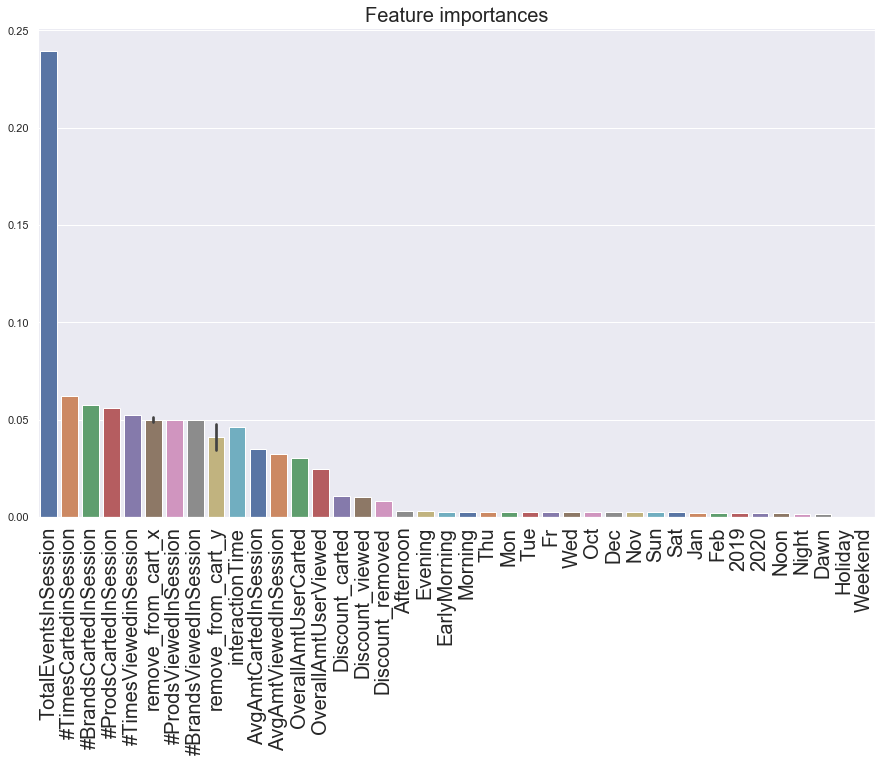

In [73]:
importances = sel.estimator_.feature_importances_
indices = np.argsort(importances)[::-1] 
colname = XData.columns[indices]
plt.figure(figsize=(15,9))
plt.title("Feature importances",size=20)
sns.barplot(x=colname, y=importances[indices],palette="deep")
plt.xticks(rotation=90,size=20)
plt.show()

## Using F Scores

In [74]:
import sklearn.feature_selection as fs
kb = fs.SelectKBest(k=X_train.shape[1])
kb.fit(X_train, y_train)
names = XData.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))

In [75]:
fScoreDF = pd.DataFrame(data = names_scores, columns=['Feat_names','F_Scores'])
fScoreDF_sorted = fScoreDF.sort_values(['F_Scores','Feat_names'], ascending =[False, True])

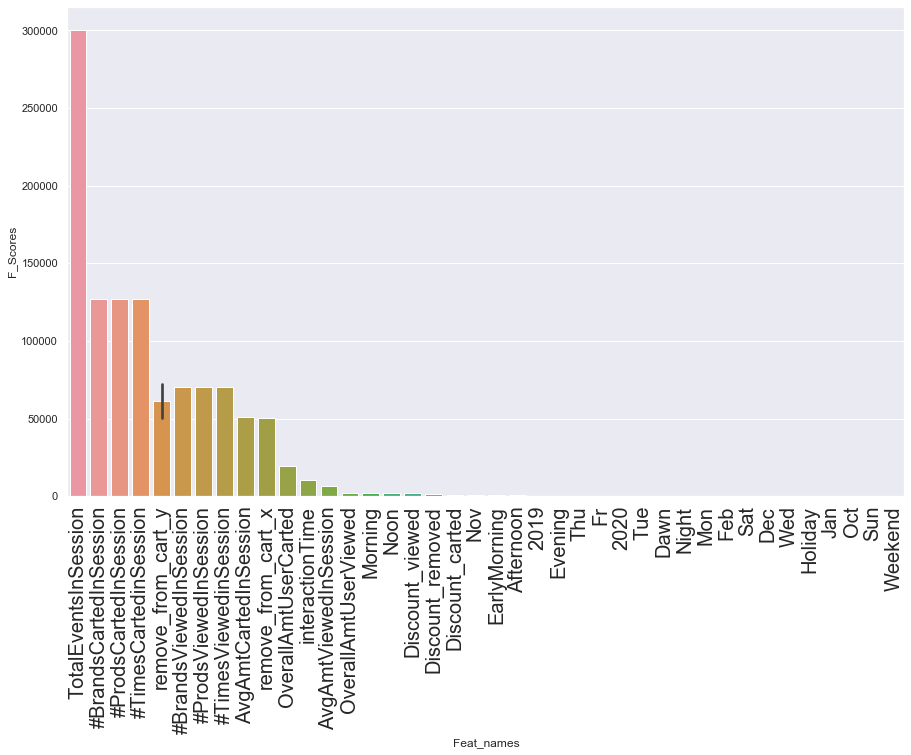

In [76]:
plt.figure(figsize=(15,9))
sns.barplot(x= "Feat_names", y="F_Scores",data=fScoreDF_sorted)
plt.xticks(rotation=90,size=20)
plt.show()

In [66]:
FeaturesDF

,TotalEventsInSession,interactionTime,#TimesCartedinSession,remove_from_cart_x,#TimesViewedinSession,AvgAmtCartedInSession,remove_from_cart_y,AvgAmtViewedInSession,#BrandsCartedInSession,remove_from_cart_x,#BrandsViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,#ProdsCartedInSession,remove_from_cart_y,#ProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,2020,Dec,Feb,Jan,Nov,Oct,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Holiday,Weekend,Purchase
0,1,0.0,0,0,1,0.000000,0.000000,194.440000,0,0,1,4.543833,9.244298,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1,1,0.0,0,0,1,0.000000,0.000000,25.710000,0,0,1,0.000000,25.710000,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0.0,0,0,1,0.000000,0.000000,0.790000,0,0,1,3.016667,2.380000,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,20,7483.0,1,8,2,0.380000,1.581250,0.430000,1,8,2,4.104850,6.297151,1,8,2,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,2,756.0,0,0,2,0.000000,0.000000,5.710000,0,0,2,4.100714,4.532431,0,0,2,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535935,34,1250237.0,6,11,17,3.701667,4.568182,4.499412,6,11,17,3.384384,3.565106,6,11,17,0,0,1,0,1,0,1,1,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0
4535936,1,0.0,0,0,1,0.000000,0.000000,4.440000,0,0,1,0.000000,4.440000,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4535937,1,0.0,0,0,1,0.000000,0.000000,9.520000,0,0,1,0.000000,9.520000,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4535938,8,947.0,7,0,1,3.900000,0.000000,7.940000,7,0,1,4.971290,7.038874,7,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [76]:
all_features = FeaturesDF.loc[:,['TotalEventsInSession','#BrandsCartedInSession','#ProdsCartedInSession','#TimesCartedinSession','remove_from_cart_y','Purchase']]

In [77]:
all_features.to_csv('all_features.csv')

# BASELINING --- TO BE DONE

## Using KNN

In [1005]:
pca = PCA(.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [1006]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [1009]:
classifier = KNeighborsClassifier(n_neighbors = 4)

In [1010]:
y_pred = cross_val_predict(classifier, X_train, y_train, cv=5)

In [1011]:
print(metrics.accuracy_score(y_train, y_pred))

0.9604974396488661


In [1012]:
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [1013]:
predFinal = classifier.predict(X_test)

In [1014]:
print(metrics.accuracy_score(y_test, predFinal))

0.9473684210526315


In [1018]:
cnf_matrix = confusion_matrix(y_test, predFinal)
cnf_matrix

array([[324,   1],
       [ 17,   0]])

Text(0.5, 3.5, 'Predicted label')

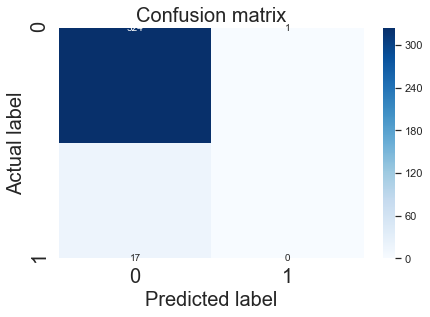

In [1019]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names,size=20)
plt.yticks(tick_marks, class_names,size=20)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('Confusion matrix',size = 20)
plt.ylabel('Actual label',size = 20)
plt.xlabel('Predicted label',size = 20)

## Using LR